# 自动化特征选择

有了这么多种创建新特征的方法，你可能会想要增大数据的维度，使其远大于原始特征的数量。但是，添加更多特征会使所有模型变得更加复杂，从而增大过拟合的可能性。在添加新特征或处理一般的高维数据集时，最好将特征的数量减少到只包含最有用的那些特征，并删除其余特征。这样会得到泛化能力更好、更简单的模型。但你如何判断每个特征的作用有多大呢?有三种基本的策略:**单变量统计** (univariate statistics)、**基于模型的选择**(model-based selection)和**迭代选择** (iterative selection)。我们将详细讨论这三种策略。所有这些方法都是监督方法，即它们需要目标值来拟合模型。这也就是说，我们需要将数据划分为训练集和测试集，并只在训练集上拟合特征选择

## 单变量统计

在单变量统计中，我们计算每个特征和目标值之间的关系是否存在统计显著性，然后选择具有最高置信度的特征。对于分类问题，这也被称为**方差分析** (analysis of variance,ANOVA)。这些测试的一个关键性质就是它们是**单变量的** (univariate)，即它们只单独考虑每个特征。因此，如果一个特征只有在与另一个特征合并时才具有信息量，那么这个特征将被舍弃。单变量测试的计算速度通常很快，并且不需要构建模型。另一方面，它们完全独立于你可能想要在特征选择之后应用的模型。

想要在scikit-learn 中使用单变量特征选择，你需要选择一项测试一对分类向题通常是f_classif(默认值)，对回归问题通常是 f_regression-然后基于测试中确定的p值来选择一种舍弃特征的方法。所有舍弃参数的方法都使用闽值来舍弃所有D值过大的特征(意味着它们不可能与目标值相关)。计算阙值的方法各有不同，最简单的是 SelectKBest和SelectPercentle，前者选择固定数量的k个特征，后者选择固定百分比的特征。我们将分类的特征选择应用于cancer 数据集。为了使任务更难一点，我们将向数据中添加一些没有信息量的噪声特征。我们期望特征选择能能够识别没有信息量的特征并删除它们:

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
import numpy as np


cancer = load_breast_cancer()

# 获得确定性的随机函数
rng = np.random.RandomState(42)
noise = rng.normal(size = (len(cancer.data), 50))
# 向数据中添加噪声
# 前30个来自数据后50个是噪声
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)
# 使用f_classif（默认值）和 SelectPercentile 来选择50%的特征
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

# 对训练数据集进行变化
X_train_selected = select.transform(X_train)

np.set_printoptions(precision=3, suppress=True, floatmode='fixed')
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


如你所见，特征的数量从80减少到40 (原始特征数量的50%)。我们可以用get.support 方法来查看哪些特征被选中，它会返回所选特征的布尔遮罩(mask)

Text(0.5, 0, 'Sample index')

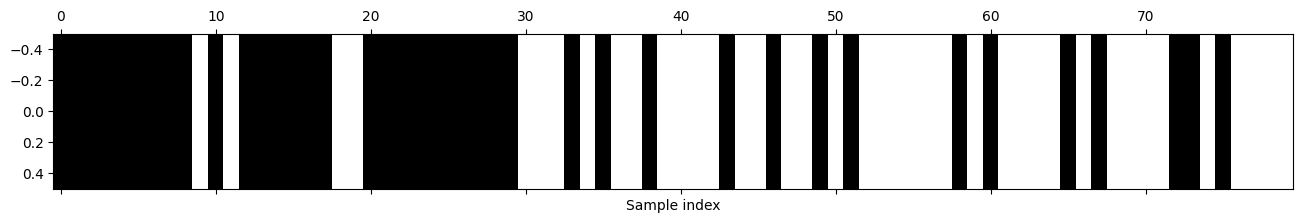

In [2]:
import matplotlib.pyplot as plt
mask = select.get_support()
mask
# 将遮罩可视化，黑色为True，白色为Flase
plt.matshow(mask.reshape(-1, 1).T, cmap='gray_r', aspect='auto',)
plt.xlabel("Sample index")


你可以从遮罩的可视化中看出，大多数所选择的特征都是原始特征，并且大多数噪声特征都已被删除。但原始特征的还原并不完美。我们来比较 Logistic 回归在所有特征上的性能与仅使用所选特征的性能:

In [3]:
from sklearn.linear_model import LogisticRegression

# 对数据进行变换
from sklearn.linear_model import LogisticRegression

# transform test data
X_test_selected = select.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    lr.score(X_test_selected, y_test)))

D:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score with all features: 0.930
Score with only selected features: 0.937


D:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


在这个例子中，删除噪声特征可以提高性能，即使丢失了某些原始特征。这是一个非常简单的假想示例，在真实数据上的结果要更加复杂。不过，如果特征量太大以至于无法构建模型，或者你怀疑许多特征完全没有信息量，那么单变量特征选择还是非常有用的。